# pyopencl

python でも OpenCL が手軽に実行できます。　　

C 言語で、OpenCL が利用できない場合には、まず、C 言語で OpenCL が利用できる環境を整えてください。　　

その上で、以下のように、pyopencl をインストールすると、python から OpenCL が扱えるようになります。  

これは、Google Colaboratory でも実行できます(ランタイムタイプを GPU にして利用して下さい)。  

In [ ]:
!pip install pyopencl

## デバイスと環境の調査

正常に pyopencl が利用できる環境で以下のプログラムを実行すると clinfo のような環境情報が表示されます。  

In [1]:
import pyopencl as cl

for platform in cl.get_platforms():
	print("===================================================")
	print("Platform Name               ", platform.name)
	print("Platform Vendor             ", platform.vendor)
	print("Platform Version            ", platform.version)
	print("Platform Profile            ", platform.profile)
	print("Platform Extensions         ", platform.extensions)
	for device in platform.get_devices():
		print("---------------------------------------------------")
		print("Device Name                 ", device.name)
		print("Device Vendor               ", device.vendor)
		print("Device Version              ", device.version)
		print("Driver Version              ", device.driver_version)
		print("Device OpenCL C Version     ", device.opencl_c_version)
		print("Device Type                 ", cl.device_type.to_string(device.type))
		print("Device Profile              ", device.profile)
		print("Max compute units           ", device.max_compute_units)
		print("Max clock frequency         ", device.max_clock_frequency, 'MHz')
		print("Compute Capability          ", device.compute_capability_major_nv, '.', device.compute_capability_minor_nv)
		print("Device memory               ", device.global_mem_size//1024//1024, 'MB')
		print("Max work item dimensions    ", device.max_work_item_dimensions)
		print("Max work item size          ", device.max_work_item_sizes)
		print("Max work group size         ", device.max_work_group_size)
		print("Warp size (NV)              ", device.warp_size_nv)

Platform Name                NVIDIA CUDA
Platform Vendor              NVIDIA Corporation
Platform Version             OpenCL 1.1 CUDA 6.5.51
Platform Profile             FULL_PROFILE
Platform Extensions          cl_khr_byte_addressable_store cl_khr_icd cl_khr_gl_sharing cl_nv_compiler_options cl_nv_device_attribute_query cl_nv_pragma_unroll cl_nv_copy_opts 
---------------------------------------------------
Device Name                  GeForce 9400M
Device Vendor                NVIDIA Corporation
Device Version               OpenCL 1.0 CUDA
Driver Version               340.108
Device OpenCL C Version      OpenCL C 1.0 
Device Type                  ALL | GPU
Device Profile               FULL_PROFILE
Max compute units            2
Max clock frequency          1100 MHz
Compute Capability           1 . 1
Device memory                253 MB
Max work item dimensions     3
Max work item size           [512, 512, 64]
Max work group size          512
Warp size (NV)               32


## 行列積の実行

以下のプログラムで、numpy と OpenCL の両方で、整数と実数の場合の行列積を計算します。  

python のヒアドキュメントの機能により、OpenCL のカーネルプログラムがベタで記述できるのは良いです。  

In [2]:
import numpy as np
import pyopencl as cl
import time

size = 1024

src = '''//CL//
__kernel void matmul(
	__global const float* a,
	__global const float* b,
	__global float* c,
			 const int n)
{
	const int i = get_global_id(0);
	const int j = get_global_id(1);
	float tmp = 0.0;

	for(int k = 0; k < n; k++) {
		tmp += a[j * n + k] * b[k * n + i];
	}
	c[j * n + i] = tmp; 
}
'''

print('Matrix multiplication float size : ', size)

a = np.random.rand(size, size).astype(np.float32)
b = np.random.rand(size, size).astype(np.float32)
a = 2.0 * a - 1.0
b = 2.0 * b - 1.0

tmst = time.time()
c = np.matmul(a, b)
tmed = time.time()

print('Numpy  time : ', tmed - tmst)

contx = cl.create_some_context(interactive=False)
queue = cl.CommandQueue(contx)
prgrm = cl.Program(contx, src).build()
mf = cl.mem_flags
abuf = cl.Buffer(contx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=a)
bbuf = cl.Buffer(contx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=b)
cbuf = cl.Buffer(contx, mf.WRITE_ONLY, c.nbytes)
n = np.int32(size)

tmst = time.time()
event = prgrm.matmul(queue, c.shape, None, abuf, bbuf, cbuf, n)
event.wait()
tmed = time.time()

cout = np.empty_like(c)
cl.enqueue_copy(queue, cout, cbuf)

print('OpenCL time : ', tmed - tmst)
print('Max Min result diff : ', np.max(cout - c), ',', np.min(cout - c))



src = '''//CL//
__kernel void matmul(
	__global const int* a,
	__global const int* b,
	__global int* c,
			 const int n)
{
	const int i = get_global_id(0);
	const int j = get_global_id(1);
	int tmp = 0.0;

	for(int k = 0; k < n; k++) {
		tmp += a[j * n + k] * b[k * n + i];
	}
	c[j * n + i] = tmp; 
}
'''

print('Matrix multiplication integer size : ', size)

a = np.random.randint(-256, 256, (size, size)).astype(np.int32)
b = np.random.randint(-256, 256, (size, size)).astype(np.int32)

tmst = time.time()
c = np.matmul(a, b)
tmed = time.time()

print('Numpy  time : ', tmed - tmst)

contx = cl.create_some_context(interactive=False)
queue = cl.CommandQueue(contx)
prgrm = cl.Program(contx, src).build()
mf = cl.mem_flags
abuf = cl.Buffer(contx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=a)
bbuf = cl.Buffer(contx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=b)
cbuf = cl.Buffer(contx, mf.WRITE_ONLY, c.nbytes)
n = np.int32(size)

tmst = time.time()
event = prgrm.matmul(queue, c.shape, None, abuf, bbuf, cbuf, n)
event.wait()
tmed = time.time()

cout = np.empty_like(c)
cl.enqueue_copy(queue, cout, cbuf)

print('OpenCL time : ', tmed - tmst)
print('Max Min result diff : ', np.max(cout - c), ',', np.min(cout - c))

Matrix multiplication float size :  1024
Numpy  time :  0.11262202262878418
OpenCL time :  1.0116124153137207
Max Min result diff :  8.392334e-05 , -6.67572e-05
Matrix multiplication integer size :  1024
Numpy  time :  17.078879594802856
OpenCL time :  0.9658496379852295
Max Min result diff :  0 , 0


ご利用の計算機環境によりますが、numpy は整数の計算が遅いというのは言えそうです。  

## マンデルブロ集合とジュリア集合

マンデルブロ集合とジュリア集合を OpenCL を使って計算し、表示してみます。  

time :  0.020096540451049805


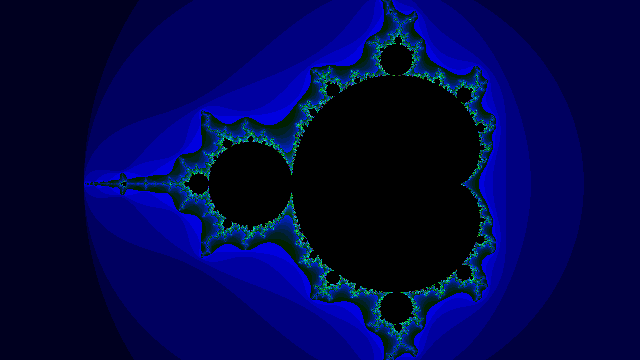

In [1]:
import numpy as np
import pyopencl as cl
import time
from PIL import Image

src = '''//CL
__kernel void mandel(
	__global uchar* out,
	const float zr,
	const float zi,
	const float zd,
	const float cr, 
	const float ci, 
	const float cd 
)
{
	const float threshold = 4.0;
	const int max = 256;
	const int i = get_global_id(1);
	const int j = get_global_id(0);
	float wr = zr + zd * i;
	float wi = zi + zd * j;
	float ar = cr + cd * i;
	float ai = ci + cd * j;
	float wr2, wi2, wri;
	int k;
	for(k = 0; k < max; k++) {
		wri = wr * wi;
		wr2 = wr * wr;
		wi2 = wi * wi;
		wr  = wr2 - wi2 + ar;
		wi  = wri + wri + ai;
		if(wr2 + wi2 > threshold) {
			break;
		}
	}
	if(k > 255){
		k = 0;
	}
	const int idx = (j * get_global_size(1) + i) * 3;
	const int im = 8;
	out[idx + 2] =  (k % im) * 256 / im;
	out[idx + 1] = ((k / im) % im) * 256 / im;
	out[idx + 0] = ((k / im  / im) % im) * 256 / im;
}
'''

width = 640
height = 360
zr  = np.float32(0.0)
zi  = np.float32(0.0)
zd  = np.float32(0.0)
cr  = np.float32(-2.5)
ci  = np.float32(-1.1)
cd  = np.float32(0.006)
#zr  = np.float32(-2.0)
#zi  = np.float32(-1.1)
#zd  = np.float32(0.006)
#cr  = np.float32(-0.4)
#ci  = np.float32(-0.6)
#cd  = np.float32(0.0)
out = np.empty((height, width, 3), np.uint8)

contx = cl.create_some_context(interactive=False)
queue = cl.CommandQueue(contx)
prgrm = cl.Program(contx, src).build()
obuf  = cl.Buffer(contx, cl.mem_flags.WRITE_ONLY, out.nbytes)
timst = time.time()
event = prgrm.mandel(queue, (height, width), None, obuf, zr, zi, zd, cr, ci, cd)
event.wait()
timed = time.time()
cl.enqueue_copy(queue, out, obuf)
print('time : ', timed - timst)
image = Image.fromarray(out)
image.show()
image

## pygame でアニメーション　【番外編】

前述のように、OpenCL を使うと高速で計算できることがわかりました。  
そこで、pygame を使って、キーボードで押されたキーによってパラメータを変更して、アニメーションを表示するようにしました。  
利用するキーは、カーソルキー、a, s, d, w, z, x, n, m, ESCキーです。  

※　これは、番外編のため、jupyter lab や notebook では、表示できません。また、pygame のインストールも必要です。  

In [ ]:
import numpy as np
import pyopencl as cl
from PIL import Image
import pygame as pg

src = '''//CL
__kernel void mandel(
	__global uchar* out,
	const float zr,
	const float zi,
	const float zd,
	const float cr, 
	const float ci, 
	const float cd 
)
{
	const float threshold = 4.0;
	const int max = 256;
	const int i = get_global_id(1);
	const int j = get_global_id(0);
	float wr = zr + zd * i;
	float wi = zi + zd * j;
	float ar = cr + cd * i;
	float ai = ci + cd * j;
	float wr2, wi2, wri;
	int k;
	for(k = 0; k < max; k++) {
		wri = wr * wi;
		wr2 = wr * wr;
		wi2 = wi * wi;
		wr  = wr2 - wi2 + ar;
		wi  = wri + wri + ai;
		if(wr2 + wi2 > threshold) {
			break;
		}
	}
	if(k > 255){
		k = 0;
	}
	const int idx = (j * get_global_size(1) + i) * 3;
	const int im = 8;
	out[idx + 2] =  (k % im) * 256 / im;
	out[idx + 1] = ((k / im) % im) * 256 / im;
	out[idx + 0] = ((k / im  / im) % im) * 256 / im;
}
'''

def main():
	width = 640
	height = 360
	zr  = np.float32(0.0)
	zi  = np.float32(0.0)
	zd  = np.float32(0.0)
	cr  = np.float32(-2.5)
	ci  = np.float32(-1.1)
	cd  = np.float32(0.006)
#	zr  = np.float32(-2.0)
#	zi  = np.float32(-1.1)
#	zd  = np.float32(0.006)
#	cr  = np.float32(-0.4)
#	ci  = np.float32(-0.6)
#	cd  = np.float32(0.0)
	out = np.empty((height, width, 3), np.uint8)

	contx = cl.create_some_context(interactive=False)
	queue = cl.CommandQueue(contx)
	prgrm = cl.Program(contx, src).build()
	obuf  = cl.Buffer(contx, cl.mem_flags.WRITE_ONLY, out.nbytes)
	event = prgrm.mandel(queue, (height, width), None, obuf, zr, zi, zd, cr, ci, cd)
	event.wait()
	cl.enqueue_copy(queue, out, obuf)
	image = Image.fromarray(out)
	#image
	#image.show()
	pg.init()
	pg.key.set_repeat(50, 50)
	screen = pg.display.set_mode((width, height))
	raw_str = image.tobytes("raw", 'RGB')
	surface = pg.image.fromstring(raw_str, (width, height), 'RGB')
	screen.blit(surface, (0,0))
	pg.display.update()
	update = False
	while True:
		for event in pg.event.get():
			if event.type == pg.QUIT:
				pg.quit()
				return
			if event.type == pg.KEYDOWN:
				if event.key == pg.K_ESCAPE:
					pg.quit()
					return
				update = True
				if event.key == pg.K_z:
					zd = np.float32(zd + 0.0001)
				if event.key == pg.K_x:
					zd = np.float32(zd - 0.0001)
				if event.key == pg.K_w:
					zi = np.float32(zi + 0.01)
				if event.key == pg.K_s:
					zi = np.float32(zi - 0.01)
				if event.key == pg.K_a:
					zr = np.float32(zr + 0.01)
				if event.key == pg.K_d:
					zr = np.float32(zr - 0.01)
				if event.key == pg.K_n:
					cd = np.float32(cd + 0.0001)
				if event.key == pg.K_m:
					cd = np.float32(cd - 0.0001)
				if event.key == pg.K_UP:
					ci = np.float32(ci + 0.01)
				if event.key == pg.K_DOWN:
					ci = np.float32(ci - 0.01)
				if event.key == pg.K_LEFT:
					cr = np.float32(cr + 0.01)
				if event.key == pg.K_RIGHT:
					cr = np.float32(cr - 0.01)
		if update :
			update = False
			event = prgrm.mandel(queue, (height, width), None, obuf, zr, zi, zd, cr, ci, cd)
			event.wait()
			cl.enqueue_copy(queue, out, obuf)
			image = Image.fromarray(out)
			raw_str = image.tobytes("raw", 'RGB')
			surface = pg.image.fromstring(raw_str, (width, height), 'RGB')
			screen.blit(surface, (0,0))
			pg.display.update()
			print(zr, zi, zd, cr, ci, cd)
	pg.quit()

if __name__ == '__main__':
	main()

アニメーションのテスト実行のビデオです。
マンデルブロ集合からジュリア集合へパラメータを徐々に変えました。

<video controls width="640" height="320" src="img/pyopencl-mandel2julia.mp4"></video>